In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('data/ObesityDataSet_raw_and_data_sinthetic.csv')
target = df['NObeyesdad']
df = df.drop('NObeyesdad', axis=1)

def scale(old_dataframe):
    dataframe = old_dataframe.copy(deep=True)
    dataframe['FAVC'] = dataframe['FAVC'].apply(lambda x: int(x == "yes"))
    dataframe['SCC'] = dataframe['SCC'].apply(lambda x: int(x == "yes"))
    dataframe['SMOKE'] = dataframe['SMOKE'].apply(lambda x: int(x == "yes"))
    dataframe['family_history_with_overweight'] = \
        dataframe['family_history_with_overweight'].apply(lambda x: int(x == "yes"))

    dataframe = pd.get_dummies(dataframe, columns=['Gender', 'MTRANS', 'CAEC', 'CALC'], dtype=int)
    scaler = StandardScaler()
    return scaler.fit_transform(dataframe)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Age                             2111 non-null   float64
 1   Gender                          2111 non-null   object 
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   CALC                            2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   SCC                             2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  family_history_with_overweight  2111 non-null   object 
 12  FAF                             21

## Дерево принятия решений

In [2]:
from DTClassifier import DTClassifier

X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.7)

dt = DTClassifier(stopping_criteria="depth_threshold", depth_threshold=3)
dt.fit(X_train, y_train)
dt_prediction = dt.predict(X_test)
accuracy_score(y_test, dt_prediction)

0.6324921135646687

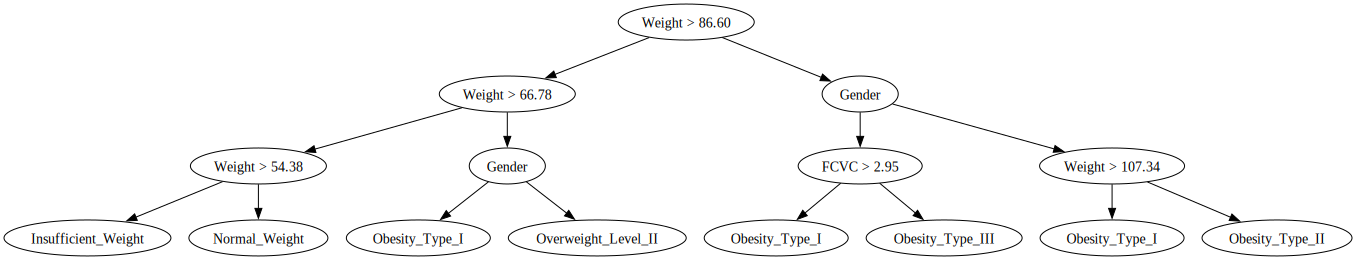

In [3]:
from IPython.display import display, SVG

dt.build_svg()
display(SVG('tree.svg'))

## Случайный лес

In [9]:
from RFClassifier import RFClassifier

rf = RFClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=5)
rf.fit(X_train, y_train)
rf_prediction = rf.predict(X_test)
accuracy_score(y_test, rf_prediction)

0.5283911671924291

## Бустинг (AdaBoost)

In [10]:
from BoostClassifier import BoostClassifier

boost = BoostClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=5)
boost.fit(X_train, y_train)
boost_prediction = boost.predict(X_test)
accuracy_score(y_test, boost_prediction)

0.5930599369085173

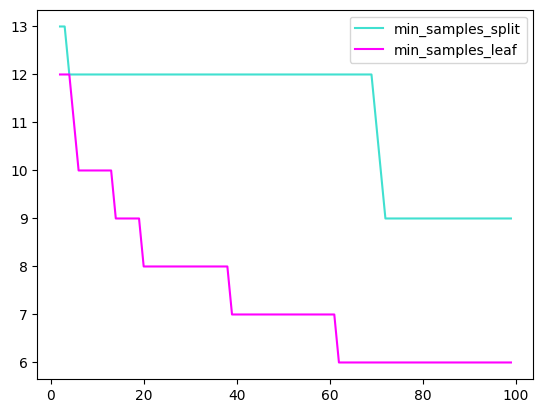

In [6]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

X_train, X_test, y_train, y_test = train_test_split(scale(df), target, train_size=0.7)

depth_min_samples_split = []
depth_min_samples_leaf = []

for min_samples_split in range(2, 100):
    tree = DecisionTreeClassifier(min_samples_split=min_samples_split)
    tree.fit(X_train, y_train)
    depth_min_samples_split.append(tree.get_depth())

for min_samples_leaf in range(2, 100):
    tree = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    tree.fit(X_train, y_train)
    depth_min_samples_leaf.append(tree.get_depth())

plt.plot(range(2, 100), depth_min_samples_split, c='turquoise', label='min_samples_split')
plt.plot(range(2, 100), depth_min_samples_leaf, c='magenta', label='min_samples_leaf')
plt.legend()
plt.show()

In [14]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['none', 'gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 20)
    classifier = DTClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=5
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 14:05:44,696] A new study created in memory with name: no-name-b259f244-4787-423b-8966-68a742326c3d
[I 2024-05-30 14:05:44,723] Trial 0 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 76}. Best is trial 0 with value: 0.1726454420522217.
[I 2024-05-30 14:05:44,743] Trial 1 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 12}. Best is trial 0 with value: 0.1726454420522217.
[I 2024-05-30 14:05:46,315] Trial 2 finished with value: 0.6865231333027942 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 4}. Best is trial 2 with value: 0.6865231333027942.
[I 2024-05-30 14:05:48,021] Trial 3 finished with value: 0.8070293174530463 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 5}. Best is trial 3 with value: 0.8070293174530463.
[I 2024-05-30 14:05:48,039] Trial 4 finished with value: 0.1726454420522

In [15]:
study.best_value, study.best_params

(0.8937127805771874,
 {'stopping_criteria': 'depth_threshold', 'depth_threshold': 13})

In [16]:
def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 10)
    n_trees = trial.suggest_int('n_trees', 2, 25)
    classifier = RFClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold, n_trees)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=5
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 14:08:06,716] A new study created in memory with name: no-name-47e9c3e1-8ba9-4974-bda3-3d0f02db372b
[I 2024-05-30 14:08:18,903] Trial 0 finished with value: 0.8083142464498396 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 9, 'n_trees': 15}. Best is trial 0 with value: 0.8083142464498396.
[I 2024-05-30 14:08:19,132] Trial 1 finished with value: 0.31213467704993125 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 1, 'n_trees': 7}. Best is trial 0 with value: 0.8083142464498396.
[I 2024-05-30 14:08:19,226] Trial 2 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'size_threshold', 'size_threshold': 18, 'n_trees': 24}. Best is trial 0 with value: 0.8083142464498396.
[I 2024-05-30 14:08:19,272] Trial 3 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.45, 'n_trees': 13}. Best is trial 0 with value: 0.8083142464498396.
[I 2024-05

In [17]:
study.best_value, study.best_params

(0.8245739807604215,
 {'stopping_criteria': 'depth_threshold', 'depth_threshold': 9, 'n_trees': 20})

In [18]:
def objective(trial):
    stopping_criteria = trial.suggest_categorical(
        'stopping_criteria', ['none', 'gain_threshold', 'size_threshold', 'depth_threshold']
    )
    gain_threshold = 0
    size_threshold = 0
    depth_threshold = 0
    if stopping_criteria == 'gain_threshold':
        gain_threshold = trial.suggest_float('gain_threshold', 0.05, 0.5, step=0.05)
    if stopping_criteria == 'size_threshold':
        size_threshold = trial.suggest_int('size_threshold', 2, 100, step=2)
    if stopping_criteria == 'depth_threshold':
        depth_threshold = trial.suggest_int('depth_threshold', 1, 10)
    n_trees = trial.suggest_int('n_trees', 2, 25)
    classifier = BoostClassifier(stopping_criteria, gain_threshold, size_threshold, depth_threshold, n_trees)
    score = cross_val_score(
        classifier, X_train, y_train, scoring='accuracy', n_jobs=5
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 14:17:25,012] A new study created in memory with name: no-name-095266e6-4281-4623-874d-d2724d9583c0
[I 2024-05-30 14:17:25,282] Trial 0 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.05, 'n_trees': 19}. Best is trial 0 with value: 0.1726454420522217.
[I 2024-05-30 14:17:25,438] Trial 1 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.25, 'n_trees': 7}. Best is trial 0 with value: 0.1726454420522217.
[I 2024-05-30 14:17:32,417] Trial 2 finished with value: 0.20651397159871734 and parameters: {'stopping_criteria': 'depth_threshold', 'depth_threshold': 1, 'n_trees': 16}. Best is trial 2 with value: 0.20651397159871734.
[I 2024-05-30 14:17:32,683] Trial 3 finished with value: 0.1726454420522217 and parameters: {'stopping_criteria': 'gain_threshold', 'gain_threshold': 0.1, 'n_trees': 19}. Best is trial 2 with value: 0.20651397159871734.
[I 202

In [19]:
study.best_value, study.best_params

(0.8117727897388913,
 {'stopping_criteria': 'depth_threshold', 'depth_threshold': 10, 'n_trees': 3})

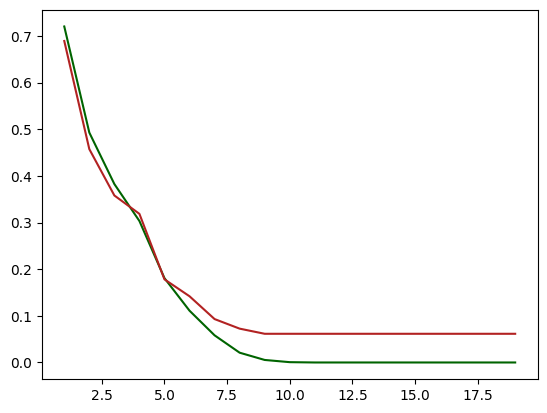

In [22]:
X_train, X_test, y_train, y_test = train_test_split(scale(df), target, train_size=0.7)

train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for depth in range(1, 20):
    model = DTClassifier(stopping_criteria="depth_threshold", depth_threshold=depth)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = DecisionTreeClassifier(max_depth=depth)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(1, 20), train_err, c='darkgreen', label='train')
plt.plot(range(1, 20), test_err, c='firebrick', label='test')
plt.legend()
plt.show()

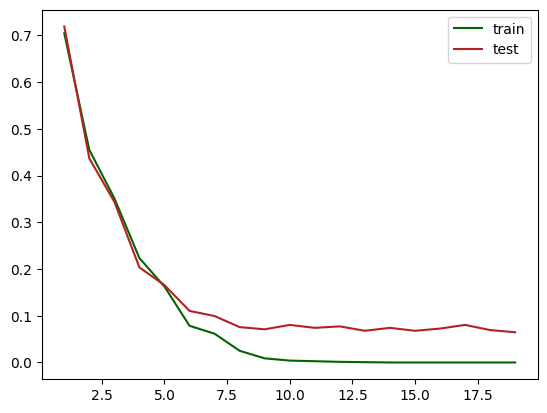

In [23]:
plt.plot(range(1, 20), lib_train_err, c='darkgreen', label='train')
plt.plot(range(1, 20), lib_test_err, c='firebrick', label='test')
plt.legend()
plt.show()

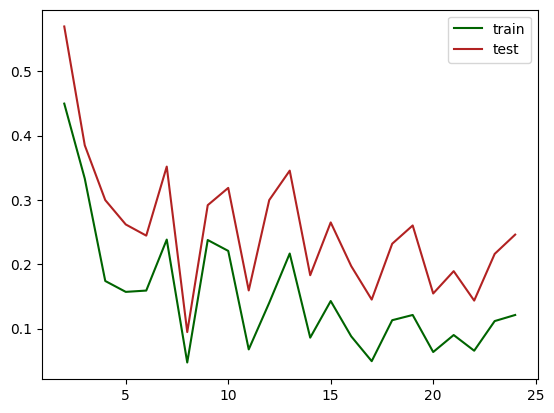

In [27]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for trees in range(2, 25):
    model = RFClassifier(stopping_criteria="depth_threshold", depth_threshold=9, n_trees=trees)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = RandomForestClassifier(max_depth=9, n_estimators=trees)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(2, 25), train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), test_err, c='firebrick', label='test')
plt.legend()
plt.show()

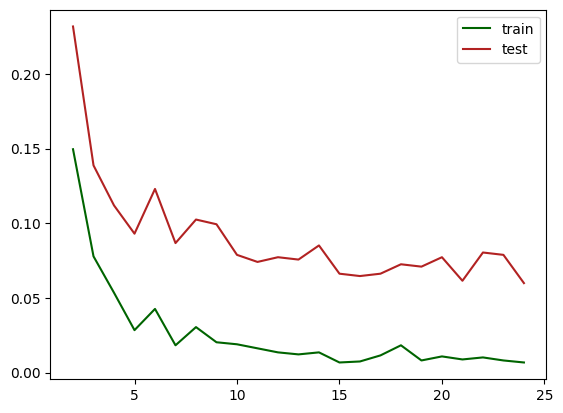

In [28]:
plt.plot(range(2, 25), lib_train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), lib_test_err, c='firebrick', label='test')
plt.legend()
plt.show()

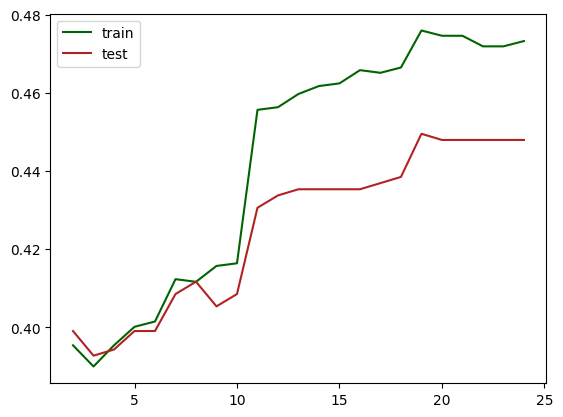

In [31]:
train_err = []
test_err = []
lib_train_err = []
lib_test_err = []

for trees in range(2, 25):
    model = BoostClassifier(stopping_criteria="depth_threshold", depth_threshold=3, n_trees=trees)
    model.fit(X_train, y_train)
    train_err.append(1 - accuracy_score(y_train, model.predict(X_train)))
    test_err.append(1 - accuracy_score(y_test, model.predict(X_test)))

    lib_model = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3), n_estimators=trees)
    lib_model.fit(X_train, y_train)
    lib_train_err.append(1 - lib_model.score(X_train, y_train))
    lib_test_err.append(1 - lib_model.score(X_test, y_test))

plt.plot(range(2, 25), train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), test_err, c='firebrick', label='test')
plt.legend()
plt.show()

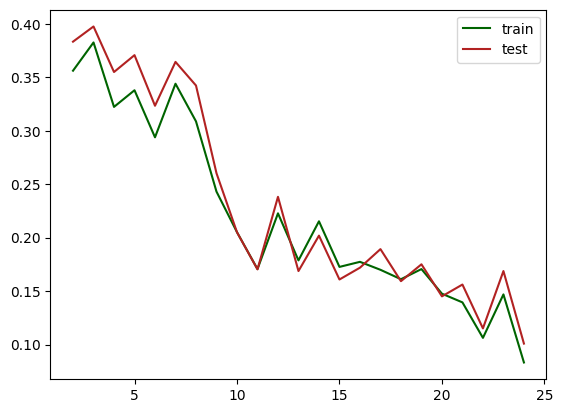

In [32]:
plt.plot(range(2, 25), lib_train_err, c='darkgreen', label='train')
plt.plot(range(2, 25), lib_test_err, c='firebrick', label='test')
plt.legend()
plt.show()

In [33]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, step=2)
    classifier = DecisionTreeClassifier(
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 15:26:41,712] A new study created in memory with name: no-name-d0fc8725-1c7a-4ba6-a683-c435f6f58527
[I 2024-05-30 15:26:41,774] Trial 0 finished with value: 0.7013742556115437 and parameters: {'criterion': 'log_loss', 'max_depth': 20, 'min_samples_split': 88, 'min_samples_leaf': 98}. Best is trial 0 with value: 0.7013742556115437.
[I 2024-05-30 15:26:41,855] Trial 1 finished with value: 0.8388593678424187 and parameters: {'criterion': 'log_loss', 'max_depth': 7, 'min_samples_split': 60, 'min_samples_leaf': 16}. Best is trial 1 with value: 0.8388593678424187.
[I 2024-05-30 15:26:41,915] Trial 2 finished with value: 0.805027485112231 and parameters: {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 94, 'min_samples_leaf': 10}. Best is trial 1 with value: 0.8388593678424187.
[I 2024-05-30 15:26:41,996] Trial 3 finished with value: 0.7995991754466332 and parameters: {'criterion': 'entropy', 'max_depth': 11, 'min_samples_split': 84, 'min_samples_leaf': 40}. Best is t

In [34]:
study.best_value, study.best_params

(0.9248694457169033,
 {'criterion': 'entropy',
  'max_depth': 14,
  'min_samples_split': 6,
  'min_samples_leaf': 2})

In [35]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 100, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 100, step=2)
    n_estimators = trial.suggest_int('n_estimators', 2, 100, step=2)
    classifier = RandomForestClassifier(
        n_estimators=n_estimators,
        criterion=criterion,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 15:26:51,494] A new study created in memory with name: no-name-d3b3fbe3-3315-4d3e-9580-3b817f933a5f
[I 2024-05-30 15:26:51,675] Trial 0 finished with value: 0.593098946404031 and parameters: {'criterion': 'log_loss', 'max_depth': 5, 'min_samples_split': 66, 'min_samples_leaf': 98, 'n_estimators': 14}. Best is trial 0 with value: 0.593098946404031.
[I 2024-05-30 15:26:52,870] Trial 1 finished with value: 0.6668781493357765 and parameters: {'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 18, 'min_samples_leaf': 70, 'n_estimators': 48}. Best is trial 1 with value: 0.6668781493357765.
[I 2024-05-30 15:26:53,662] Trial 2 finished with value: 0.6939693082913422 and parameters: {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 6, 'min_samples_leaf': 64, 'n_estimators': 76}. Best is trial 2 with value: 0.6939693082913422.
[I 2024-05-30 15:26:53,996] Trial 3 finished with value: 0.6283073751717819 and parameters: {'criterion': 'gini', 'max_depth': 3, 'min_sa

In [36]:
study.best_value, study.best_params

(0.9004878607420981,
 {'criterion': 'gini',
  'max_depth': 11,
  'min_samples_split': 4,
  'min_samples_leaf': 4,
  'n_estimators': 28})

In [39]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 2, 100, step=2)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 10, log=True)
    classifier = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(criterion='entropy', max_depth=14),
        n_estimators=n_estimators,
        learning_rate=learning_rate
    )
    score = cross_val_score(
        classifier, X_train, y_train
    )
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2024-05-30 15:30:05,017] A new study created in memory with name: no-name-3eef349e-1d70-48fd-b330-918451b1740f
[I 2024-05-30 15:30:05,135] Trial 0 finished with value: 0.9289166284928998 and parameters: {'n_estimators': 94, 'learning_rate': 0.8629753786685367}. Best is trial 0 with value: 0.9289166284928998.
[I 2024-05-30 15:30:05,253] Trial 1 finished with value: 0.9329729729729731 and parameters: {'n_estimators': 24, 'learning_rate': 0.17360474492050182}. Best is trial 1 with value: 0.9329729729729731.
[I 2024-05-30 15:30:05,375] Trial 2 finished with value: 0.934340357306459 and parameters: {'n_estimators': 34, 'learning_rate': 0.6256416693198482}. Best is trial 2 with value: 0.934340357306459.
[I 2024-05-30 15:30:05,495] Trial 3 finished with value: 0.9329821346770499 and parameters: {'n_estimators': 52, 'learning_rate': 0.33469405183505413}. Best is trial 2 with value: 0.934340357306459.
[I 2024-05-30 15:30:05,613] Trial 4 finished with value: 0.9329844251030691 and parameters:

In [40]:
study.best_value, study.best_params

(0.9397549244159414,
 {'n_estimators': 38, 'learning_rate': 0.46606829412233114})